# Multi-layer Perceptron Neural Network using sklearn

Sources:

https://github.com/mdeff/fma

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


import sys

sys.path.append('../')

from dependencies import utils

### Data Preprocessing
Let's first load and create the dataframe using the "small" dataset (1000 tracks per genre). Then we'll split the data 80/20 for training/testing and scale it.

In [5]:
tracks = utils.load('../dependencies/fma_metadata/tracks.csv')
feats = utils.load('../dependencies/fma_metadata/features.csv')

In [6]:
small = tracks['set', 'subset'] <= 'small'

X = feats.loc[small]
y = tracks['track', 'genre_top'].loc[small]

In [7]:
# Uncomment and run for 5 genre classification, otherwise default is 8 genres
#y = y.loc[(y == 'Rock') | (y == 'Electronic') | (y == 'Instrumental') | (y == 'Hip-Hop') | (y == 'Pop')]

In [8]:
# Uncomment and run for top 5 features only, otherwise default is full features
#mfcc = X.iloc[:, X.columns.get_loc('mfcc')]
#rmse = X.iloc[:, X.columns.get_loc('rmse')]
#spectral_bandwidth = X.iloc[:, X.columns.get_loc('spectral_bandwidth')]
#spectral_centroid = X.iloc[:, X.columns.get_loc('spectral_centroid')]
#spectral_contrast = X.iloc[:, X.columns.get_loc('spectral_contrast')]

In [9]:
print(y.value_counts())
X = X.loc[X.index.isin(y.index)]

# Create training and testing data with 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

Electronic             1000
Experimental           1000
Folk                   1000
Hip-Hop                1000
Instrumental           1000
International          1000
Pop                    1000
Rock                   1000
Blues                     0
Classical                 0
Country                   0
Easy Listening            0
Jazz                      0
Old-Time / Historic       0
Soul-RnB                  0
Spoken                    0
Name: (track, genre_top), dtype: int64


In [10]:
sc = StandardScaler()
X_train2 = X_train.copy()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Initial MLP model

Let's train an initial model with some arbitrary parameters and check the testing accuracy. We can optimize the hyperparameters later.

The classification report and confusion matrix tell us which genres our model performs better and worse in as well.

In [27]:
mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'relu', learning_rate_init = 0.2, batch_size = 300, hidden_layer_sizes = (200,100), max_iter = 300)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

In [19]:
print(mlp.classes_)

['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']


Accuracy: 0.539375

Classification Report:
               precision    recall  f1-score   support

   Electronic       0.55      0.59      0.57       203
 Experimental       0.46      0.48      0.47       211
         Folk       0.57      0.65      0.61       181
      Hip-Hop       0.62      0.58      0.60       193
 Instrumental       0.55      0.52      0.53       215
International       0.71      0.66      0.68       208
          Pop       0.34      0.42      0.37       195
         Rock       0.58      0.42      0.49       194

     accuracy                           0.54      1600
    macro avg       0.55      0.54      0.54      1600
 weighted avg       0.55      0.54      0.54      1600



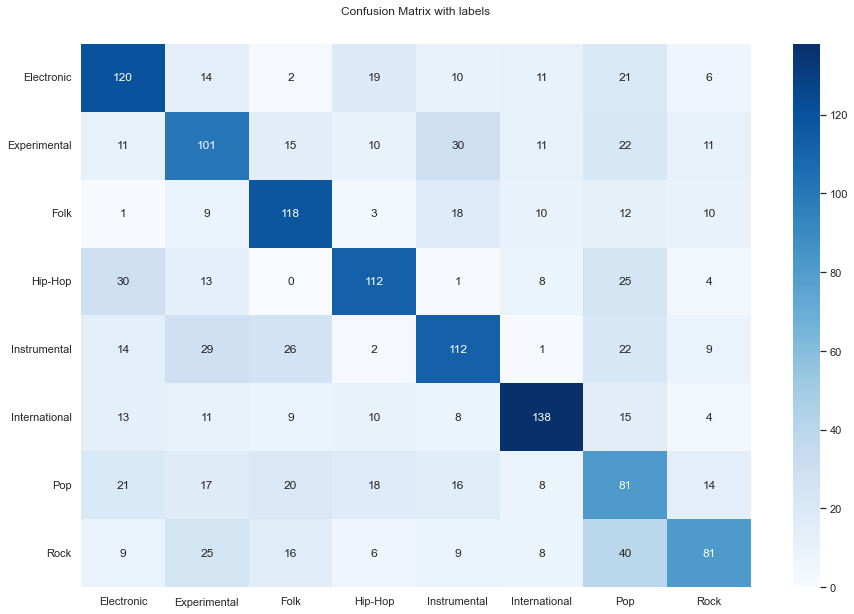

In [28]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
cf_mat = confusion_matrix(y_test, y_pred)
sns.set(rc = {'figure.figsize':(15,10)})

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
ax.set_xticklabels(mlp.classes_)
kwargs = {'rotation': 'horizontal'}
ax.set_yticklabels(mlp.classes_, **kwargs)

ax.set_title('Confusion Matrix with labels\n\n')

## Display the visualization of the Confusion Matrix.
plt.show()

### Hyperparameter Tuning

Now let's perform hyperparameter tuning using Grid Search to determine the optimal parameters for this particular model.

We can see the optimal hyperparameters below, and the updated classification report and confusion matrix show an improvement in overall accuracy.

In [ ]:
from sklearn.model_selection import GridSearchCV

learning_rate_init = [0.1, 0.2, 0.3]
max_iter = [100, 300]
hidden_layer_sizes = [(200,100), (200,50), (100,50)]
solver = ['sgd', 'adam']
random_state = [42]
activation = ['logistic', 'relu']
batch_size = [100, 300]


# Make a dictionary of the grid search parameters
param_grid = dict(learning_rate_init=learning_rate_init, max_iter=max_iter, hidden_layer_sizes=hidden_layer_sizes, solver=solver, random_state=random_state, activation=activation, batch_size=batch_size)

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator=mlp, param_grid=param_grid)

grid.fit(X_train, y_train)

In [30]:
print("Optimal Hyperparameters:", grid.best_params_)

Optimal Hyperparameters: {'activation': 'relu', 'batch_size': 300, 'hidden_layer_sizes': (200, 100), 'learning_rate_init': 0.1, 'max_iter': 100, 'random_state': 42, 'solver': 'sgd'}


Accuracy: 0.57625

Classification Report:
               precision    recall  f1-score   support

   Electronic       0.59      0.60      0.59       203
 Experimental       0.47      0.54      0.50       211
         Folk       0.56      0.64      0.59       181
      Hip-Hop       0.61      0.73      0.67       193
 Instrumental       0.64      0.57      0.60       215
International       0.71      0.59      0.65       208
          Pop       0.42      0.38      0.40       195
         Rock       0.65      0.58      0.61       194

     accuracy                           0.58      1600
    macro avg       0.58      0.58      0.58      1600
 weighted avg       0.58      0.58      0.58      1600



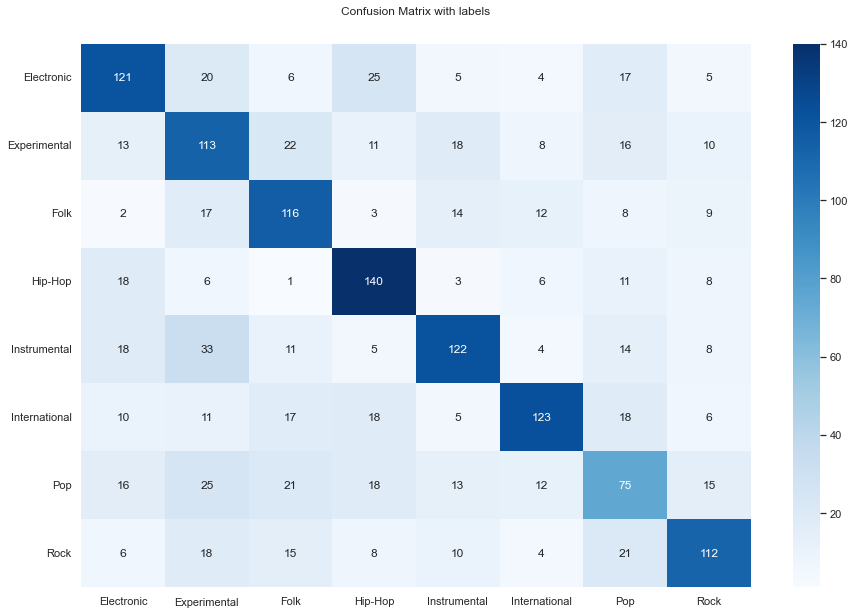

In [17]:
grid_pred = grid.predict(X_test)

print("Accuracy:", accuracy_score(y_test, grid_pred))
print("\nClassification Report:")
print(classification_report(y_test, grid_pred))
cf_mat = confusion_matrix(y_test, grid_pred)
sns.set(rc = {'figure.figsize':(15,10)})

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
ax.set_xticklabels(mlp.classes_)
kwargs = {'rotation': 'horizontal'}
ax.set_yticklabels(mlp.classes_, **kwargs)

ax.set_title('Confusion Matrix with labels\n\n')

## Display the visualization of the Confusion Matrix.
plt.show()

### Pickle (Optional)

We can serialize the model and scaler to be later integrated into the web app.

In [14]:
#import pickle

#mlp_file = 'mlp_5_class_model.pkl'
#pickle.dump(mlp, open(mlp_file, 'wb'))

#sc = StandardScaler()
#sc.fit(X_train2)
    
#sc_file = 'mlp_5_class_sc.pkl'
#pickle.dump(sc, open(sc_file, 'wb'))